# CHIP-seq Data Analysis

Identify genes that are likely to be regulated by STAT1/STAT2.

Genomic locations of transcripts were taken from here: http://genome.ucsc.edu/cgi-bin/hgTables

CHIP-seq datasets for STAT1/STAT2:
- https://www.encodeproject.org/experiments/ENCSR332EYT/ (ENCFF323QQU)
- https://www.encodeproject.org/experiments/ENCSR000EHJ/ (ENCFF431NLF)
- https://www.encodeproject.org/experiments/ENCSR000FAU/ (ENCFF747ICD)
- https://www.encodeproject.org/experiments/ENCSR000FAT/ (ENCFF204VQS)
- https://www.encodeproject.org/experiments/ENCSR000FAV/ (ENCFF181PHR)
- https://www.encodeproject.org/experiments/ENCSR000FBC/ (ENCFF545JVD)

CHIP-seq datasets for CREM:
- https://www.encodeproject.org/experiments/ENCSR839XZU/ (ENCFF091YID)
- https://www.encodeproject.org/experiments/ENCSR077DKV/ (ENCFF021XJN)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [6]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [7]:
import warnings
# warnings.filterwarnings('ignore')

In [8]:
from sklearn.decomposition import PCA

In [9]:
from sklearn.preprocessing import StandardScaler

In [ ]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/schypo')
import estimator, simulate, schypo, bootstrap, util, hypothesis_test

In [11]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig4/'
data_path = '/data/parameter_estimation/'

### Perform some basic filtering

In [13]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [14]:
def simplify_name(name):
    return name.split('.')[0]

In [15]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')


In [16]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

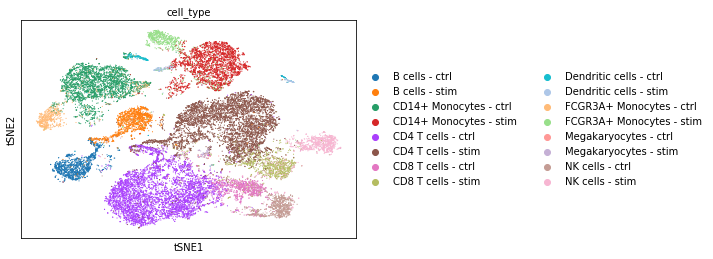

In [17]:
sc.pl.tsne(adata, color='cell_type')

In [18]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [19]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


### Get TSS windows

In [125]:
window_sizes = [0, 10, 50, 100, 500, 1000, 5000, 10000, 25000, 50000, 100000]

In [126]:
# Read the all gene information, including the tss window 
for window_size in window_sizes:
    
    gene_sites = pd.read_csv(data_path + 'chipseq/gene_locations.bed', sep='\t', header=None).iloc[:, :6]
    gene_sites.columns = ['chr', 'txStart', 'txEnd', 'name', 'score', 'strand']
    gene_sites['tss_site'] = gene_sites['txStart']*(gene_sites['strand'] == '+') + gene_sites['txEnd']*(gene_sites['strand'] == '-') 
    gene_sites['tss_window_start'] = gene_sites['tss_site'] - window_size
    gene_sites['tss_window_end'] = gene_sites['tss_site'] + window_size
    gene_sites['tss_window_start'] = gene_sites['tss_window_start']*(gene_sites['tss_window_start'] > 0) 
    gene_sites = gene_sites[['chr', 'tss_window_start', 'tss_window_end', 'name']].sort_values(['chr', 'tss_window_start'])
    gene_sites.to_csv(data_path + 'chipseq/windows/tss_window_{}.bed'.format(window_size), sep='\t', index=False, header=False)

### Create a list of STAT1/STAT2 binding sites

In [123]:
!/data/home/tools/bedtools intersect -a /data/parameter_estimation/chipseq/union/stat1.bed -b /data/parameter_estimation/chipseq/union/stat2.bed > /data/parameter_estimation/chipseq/union/intersect.bed

In [124]:
!/data/home/tools/bedtools sort -i /data/parameter_estimation/chipseq/union/intersect.bed > /data/parameter_estimation/chipseq/union/intersect.sorted.bed

In [73]:
#!cat /data/parameter_estimation/chipseq/union/ENC* > /data/parameter_estimation/chipseq/union/union.bed

In [74]:
#!/data/home/tools/bedtools sort -i /data/parameter_estimation/chipseq/union/union.bed > /data/parameter_estimation/chipseq/union/union.sorted.bed

### Get overlaps

In [206]:
!/data/home/tools/bedtools closest \
    -a /data/parameter_estimation/chipseq/windows/tss_window_0.bed \
    -b /data/parameter_estimation/chipseq/union/union.sorted.bed -d  > \
    /data/parameter_estimation/chipseq/union/union_genes/union.closest.bed

In [156]:
!/data/home/tools/bedtools closest \
    -a /data/parameter_estimation/chipseq/windows/tss_window_0.bed \
    -b /data/parameter_estimation/chipseq/union/intersect.sorted.bed -d  > \
    /data/parameter_estimation/chipseq/union/union_genes/intersect.closest.bed

In [135]:
temp[14].max()

279506

In [95]:
# !/data/home/tools/bedtools closest \
#     -a /data/parameter_estimation/chipseq/union/union.sorted.bed \
#     -b /data/parameter_estimation/chipseq/windows/tss_window_10.bed -d  > \
#     /data/parameter_estimation/chipseq/union/union_genes/10.bed

# !/data/home/tools/bedtools closest \
#     -a /data/parameter_estimation/chipseq/union/union.sorted.bed \
#     -b /data/parameter_estimation/chipseq/windows/tss_window_50.bed -d  > \
#     /data/parameter_estimation/chipseq/union/union_genes/50.bed

# !/data/home/tools/bedtools closest \
#     -a /data/parameter_estimation/chipseq/union/union.sorted.bed \
#     -b /data/parameter_estimation/chipseq/windows/tss_window_100.bed -d  > \
#     /data/parameter_estimation/chipseq/union/union_genes/100.bed

# !/data/home/tools/bedtools closest \
#     -a /data/parameter_estimation/chipseq/union/union.sorted.bed \
#     -b /data/parameter_estimation/chipseq/windows/tss_window_500.bed -d  > \
#     /data/parameter_estimation/chipseq/union/union_genes/500.bed

# !/data/home/tools/bedtools closest \
#     -a /data/parameter_estimation/chipseq/union/union.sorted.bed \
#     -b /data/parameter_estimation/chipseq/windows/tss_window_1000.bed -d  > \
#     /data/parameter_estimation/chipseq/union/union_genes/1000.bed

# !/data/home/tools/bedtools closest \
#     -a /data/parameter_estimation/chipseq/union/union.sorted.bed \
#     -b /data/parameter_estimation/chipseq/windows/tss_window_5000.bed -d  > \
#     /data/parameter_estimation/chipseq/union/union_genes/5000.bed

# !/data/home/tools/bedtools closest \
#     -a /data/parameter_estimation/chipseq/union/union.sorted.bed \
#     -b /data/parameter_estimation/chipseq/windows/tss_window_10000.bed -d  > \
#     /data/parameter_estimation/chipseq/union/union_genes/10000.bed

# !/data/home/tools/bedtools closest \
#     -a /data/parameter_estimation/chipseq/union/union.sorted.bed \
#     -b /data/parameter_estimation/chipseq/windows/tss_window_25000.bed -d  > \
#     /data/parameter_estimation/chipseq/union/union_genes/25000.bed

# !/data/home/tools/bedtools closest \
#     -a /data/parameter_estimation/chipseq/union/union.sorted.bed \
#     -b /data/parameter_estimation/chipseq/windows/tss_window_50000.bed -d  > \
#     /data/parameter_estimation/chipseq/union/union_genes/50000.bed

# !/data/home/tools/bedtools closest \
#     -a /data/parameter_estimation/chipseq/union/union.sorted.bed \
#     -b /data/parameter_estimation/chipseq/windows/tss_window_100000.bed -d  > \
#     /data/parameter_estimation/chipseq/union/union_genes/100000.bed

### Get a list of ISGF3 and IRF1 bound genes

In [157]:
conversion_df = pd.read_csv(data_path + 'chipseq/ensg_to_enst.txt', sep='\t')
conversion_df.columns = ['gene_ids', 'gene_ids_ver', 'transcript_ids', 'transcript_ids_ver']
gene_names = adata.var.reset_index().rename(columns={'index':'gene_name'})[['gene_name', 'gene_ids']]


In [207]:
distances = pd.read_csv('/data/parameter_estimation/chipseq/union/union_genes/intersect.closest.bed', sep='\t', header=None).iloc[:, [3, 14]]
distances.columns=['transcript_ids_ver', 'distance']
distances = distances.merge(conversion_df, on='transcript_ids_ver', how='inner')
distances = distances.merge(gene_names, on='gene_ids')
distances = distances.groupby('gene_name')['distance'].min().reset_index().query('distance >= 0')

distances.to_csv(data_path + 'chipseq/union/intersect_distances.csv', index=False)

In [208]:
distances = pd.read_csv('/data/parameter_estimation/chipseq/union/union_genes/union.closest.bed', sep='\t', header=None).iloc[:, [3, 14]]
distances.columns=['transcript_ids_ver', 'distance']
distances = distances.merge(conversion_df, on='transcript_ids_ver', how='inner')
distances = distances.merge(gene_names, on='gene_ids')
distances = distances.groupby('gene_name')['distance'].min().reset_index().query('distance >= 0')

distances.to_csv(data_path + 'chipseq/union/union_distances.csv', index=False)

In [204]:
distances.query('distance == 6').shape

(3, 2)

### Find CREM binding sites

In [1]:
!/data/home/tools/bedtools closest \
    -a /data/parameter_estimation/chipseq/windows/tss_window_0.bed \
    -b /data/parameter_estimation/chipseq/crem/crem.sorted.bed -d  > \
    /data/parameter_estimation/chipseq/crem/crem.closest.bed

In [20]:
conversion_df = pd.read_csv(data_path + 'chipseq/ensg_to_enst.txt', sep='\t')
conversion_df.columns = ['gene_ids', 'gene_ids_ver', 'transcript_ids', 'transcript_ids_ver']
gene_names = adata.var.reset_index().rename(columns={'index':'gene_name'})[['gene_name', 'gene_ids']]


In [21]:
distances = pd.read_csv('/data/parameter_estimation/chipseq/crem/crem.closest.bed', sep='\t', header=None).iloc[:, [3, 14]]
distances.columns=['transcript_ids_ver', 'distance']
distances = distances.merge(conversion_df, on='transcript_ids_ver', how='inner')
distances = distances.merge(gene_names, on='gene_ids')
distances = distances.groupby('gene_name')['distance'].min().reset_index().query('distance >= 0')

distances.to_csv(data_path + 'chipseq/crem/crem_distances.csv', index=False)

In [24]:
distances.query('gene_name == "SAT1"')

gene_name  distance
26768  SAT1      0

In [22]:
distances.head(5)

gene_name  distance
0  5S_rRNA   190284  
1  7SK       34883   
2  7SK-2     71195   
3  7SK-3     81800   
4  A1BG      8418

In [116]:
temp = pd.read_csv('/data/parameter_estimation/chipseq/windows/tss_window_10.bed', sep='\t', header=None)

In [122]:
temp[temp[3] == 'ENST00000649529.1']

0        1        2                  3
230  chr1  1013486  1013506  ENST00000649529.1

In [118]:
window_size = 10
df = pd.read_csv(data_path + 'chipseq/union/union_genes/{}.bed'.format(window_size), sep='\t', header=None).iloc[:, [-2, -1]]
df.columns=['transcript_ids_ver', 'distance']
df = df.query('distance == 0')
df = df.merge(conversion_df, on='transcript_ids_ver', how='inner')
df = df.merge(gene_names, on='gene_ids')
stat_genes_dict[window_size] = df['gene_name'].drop_duplicates().tolist()

In [120]:
df.query('gene_name == "ISG15"')

transcript_ids_ver  distance         gene_ids        gene_ids_ver  \
37  ENST00000649529.1  0         ENSG00000187608  ENSG00000187608.10   
38  ENST00000649529.1  0         ENSG00000187608  ENSG00000187608.10   
39  ENST00000649529.1  0         ENSG00000187608  ENSG00000187608.10   
40  ENST00000649529.1  0         ENSG00000187608  ENSG00000187608.10   
41  ENST00000649529.1  0         ENSG00000187608  ENSG00000187608.10   

     transcript_ids gene_name     mt     hb  n_cells_by_counts  mean_counts  \
37  ENST00000649529  ISG15     False  False  14816              19.357071     
38  ENST00000649529  ISG15     False  False  14816              19.357071     
39  ENST00000649529  ISG15     False  False  14816              19.357071     
40  ENST00000649529  ISG15     False  False  14816              19.357071     
41  ENST00000649529  ISG15     False  False  14816              19.357071     

    log1p_mean_counts  pct_dropout_by_counts  total_counts  log1p_total_counts  
37  3.013428           39.950553              477597.0      13.076525           
38  3.013428           39.950553              477597.0      13.076525           
39  3.013428           39.950553              477597.0      13.076525           
40  3.013428           39.950553              477597.0      13.076525           
41  3.013428           39.950553              477597.0      13.076525

In [117]:
temp

0       1       2                  3
0       chr1                 11858   11878   ENST00000456328.2
1       chr1                 11999   12019   ENST00000450305.2
2       chr1                 17426   17446   ENST00000619216.1
3       chr1                 29543   29563   ENST00000473358.1
4       chr1                 29560   29580   ENST00000488147.1
...      ...                   ...     ...                 ...
247536  chrY_KZ208924v1_fix  60090   60110   ENST00000643054.1
247537  chrY_KZ208924v1_fix  82974   82994   ENST00000647527.1
247538  chrY_KZ208924v1_fix  102167  102187  ENST00000644360.1
247539  chrY_KZ208924v1_fix  117618  117638  ENST00000645951.1
247540  chrY_KZ208924v1_fix  199271  199291  ENST00000646767.1

[247541 rows x 4 columns]

In [115]:
for gene in stat_genes_dict[10]:
    if 'IFI' in gene or 'MX' in gene[:2] or 'OAS' in gene[:3] or 'ISG' in gene or 'IRF' in gene or 'APOBEC3' in gene or 'CXCL' in gene:
        print(gene)

ISG15
IFI6
IFI44L
ISG20L2
IFI16
IFIT2
IFIT3
IFIT1
IFIT5
IFITM1
IFITM3
IRF7
OAS1
OAS3
OAS2
OASL
IRF9
IRF2BPL
IFI27
ISG20
IRF8
IFI35
IRF2BP1
IFIH1
MX2
MX1
IRF1


In [97]:
stat_genes_dict = {}
for window_size in window_sizes:
    df = pd.read_csv(data_path + 'chipseq/union/union_genes/{}.bed'.format(window_size), sep='\t', header=None).iloc[:, [-2, -1]]
    df.columns=['transcript_ids_ver', 'distance']
    df = df.query('distance == 0')
    df = df.merge(conversion_df, on='transcript_ids_ver', how='inner')
    df = df.merge(gene_names, on='gene_ids')
    stat_genes_dict[window_size] = df['gene_name'].drop_duplicates().tolist()
    
    print(window_size, len(stat_genes_dict[window_size]))

10 5407
False
50 5803
False
100 6169
False
500 7290
False
1000 7790
False
5000 9535
True
10000 11044
True
25000 14324
True
50000 17683
True
100000 21124
True


### Save the ISGF3 genes

In [ ]:
''

In [91]:
with open(data_path + 'chipseq/union/isgf3_genes.pkl', 'wb') as f:
    pkl.dump(stat_genes_dict, f)